In [19]:
import logging, os, sys
import numpy as np
import urllib.request
import shutil
import subprocess
import zipfile
import pickle
from pathlib import Path
import pandas as pd
from Pegasus.api import *

In [20]:
from util_workflow import add_input_wf_files
from util_workflow import create_file_objects, create_file_objects_postfix, create_file_objects_postfix_range

from util_workflow import download_data, unzip_flatten_data, return_corrupted_files, return_input_files
from util_workflow import split_data_filenames, add_input_tune_model,create_tar_and_pkl, create_pkl

In [21]:
# --- Import Pegasus API ---
from Pegasus.api import *
logging.basicConfig(level=logging.DEBUG)
props = Properties()
props["dagman.retry"] = "2"
props["pegasus.transfer.arguments"] = "-m 1"
props.write()

In [22]:
dataset_link = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
zip_data = "kagglecatsanddogs_3367a.zip"
directory_to_extract_to = "."

DOWNLOAD_DATA = False
DATASET_SIZE = 12
DATA_DIR = "dev_data/"
UTILS_DIR = "utils/"

arch_names = ["basicnet", "densenet121", "vgg16"]
CATS = "PetImages/Cat"
DOGS = "PetImages/Dog"
LABELS = {CATS: 0, DOGS: 1}
NUM_EPOCHS = 4
NUM_TRIALS = 3
NUM_WORKERS = 8
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)   
    
if DOWNLOAD_DATA == True:
    download_data(dataset_link)

In [23]:
# Avoid corrupted files for now
corrupted_files = return_corrupted_files("corrupted_files.txt")
# Get names of image files that will serve as inputs to the workflow
input_file_names = return_input_files(corrupted_files, DATASET_SIZE, DATA_DIR, LABELS)


#train 70%, val 10% and test 20%
train_filenames,val_filenames,test_filenames, files_split_dict = split_data_filenames(input_file_names)

workers_ids = [x for x in range(NUM_WORKERS)]
train_workers, val_workers, test_workers, _ = split_data_filenames(workers_ids)

In [24]:
rc = ReplicaCatalog()

# TRAIN, VAL and TEST data are processed separately

# Pegasus File objects are created and ADDED to the replica catalog
input_preprocess1_train = add_input_wf_files(train_filenames, DATA_DIR,rc)
input_preprocess1_val   = add_input_wf_files(val_filenames, DATA_DIR,rc)
input_preprocess1_test  = add_input_wf_files(test_filenames, DATA_DIR,rc)

# Create FILE objects with correct postfixes
postfix_job1 = "_proc1.jpg"
output_preprocess1_train = create_file_objects_postfix(train_filenames,postfix_job1)
output_preprocess1_val   = create_file_objects_postfix(val_filenames,postfix_job1)
output_preprocess1_test  = create_file_objects_postfix(test_filenames,postfix_job1)


range_num = 4
postfix = "_proc2_"
output_preprocess2_train = create_file_objects_postfix_range(train_filenames,"train_", postfix, range_num)
output_preprocess2_val = create_file_objects_postfix_range(val_filenames,"val_", postfix, range_num)
output_preprocess2_test = create_file_objects_postfix_range(test_filenames,"test_", postfix, range_num)

rc.write()

In [25]:
# Create and add our transformations to the TransformationCatalog.
tc = TransformationCatalog()

# Data preprocessing part 1 
preprocess_tc1 = Transformation(
                "preprocess1",
                site="local",
                pfn = str(Path(".").parent.resolve() / "bin/data_preprocessing1.py"), 
                is_stageable= True
            )

# Data preprocessing part 1 
preprocess_tc2 = Transformation(
                "preprocess2",
                site="local",
                pfn = str(Path(".").parent.resolve() / "bin/data_preprocessing2_args.py"), 
               is_stageable= True
            )

tc.add_transformations(preprocess_tc1, preprocess_tc2)#tune_model_vgg16,choose_best_model)
tc.write()

In [26]:
# create the preproces jobs
preprocess1_jobs_train = [Job(preprocess_tc1) for i in train_workers]
preprocess1_jobs_val   = [Job(preprocess_tc1) for i in val_workers]
preprocess1_jobs_test  = [Job(preprocess_tc1) for i in test_workers]

In [27]:
def add_job_attributes(jobs_list, input_files, output_files):
    for i in range(len(input_files)):
        curr = i % len(jobs_list)
        jobs_list[curr].add_inputs(input_files[i])
        jobs_list[curr].add_outputs( output_files[i])
    return jobs_list

In [28]:
preprocess1_jobs_train = add_job_attributes(preprocess1_jobs_train, \
                                            input_preprocess1_train,output_preprocess1_train)

preprocess1_jobs_val = add_job_attributes(preprocess1_jobs_val, \
                                            input_preprocess1_val,output_preprocess1_val)

preprocess1_jobs_test = add_job_attributes(preprocess1_jobs_test, \
                                            input_preprocess1_test,output_preprocess1_test)

In [13]:
preprocess2_jobs_train = [Job(preprocess_tc2).add_args("train") for i in train_workers]
preprocess2_jobs_val   = [Job(preprocess_tc2).add_args("val") for i in val_workers]
preprocess2_jobs_test  = [Job(preprocess_tc2).add_args("test") for i in test_workers]

In [14]:
def add_job_attributes_range(jobs_list, input_files, output_files,range_num):
    for i in range(len(input_files)):
        curr = i % len(jobs_list)
        jobs_list[curr].add_inputs(input_files[i])
        j = i*range_num
        jobs_list[curr].add_outputs(*output_files[j:(j+range_num)])
    return jobs_list   

In [17]:
#preprocess2_jobs_train = add_job_attributes_range(preprocess2_jobs_train, \
#                                            output_preprocess1_train,output_preprocess2_train,range_num)

preprocess2_jobs_val = add_job_attributes_range(preprocess2_jobs_val, \
                                            output_preprocess1_val,output_preprocess2_val,range_num)

#preprocess2_jobs_test = add_job_attributes_range(preprocess2_jobs_test, \
#                                            output_preprocess1_test,output_preprocess2_test,range_num)

In [18]:
# Set infer_dependencies=True so that they are inferred based on job input and output file usage.
wf = Workflow("catVsdog-test-wf", infer_dependencies=True)
wf.add_jobs(*preprocess1_jobs_train,*preprocess1_jobs_val,*preprocess1_jobs_test,*preprocess2_jobs_val),
 #          *preprocess2_jobs_train,*preprocess2_jobs_val, *preprocess2_jobs_test )


(<Pegasus.api.workflow.Workflow at 0x7f927c8e84e0>,)

In [19]:
try:
    wf.plan(submit=True)\
    .wait()\
    .analyze()\
    .statistics()
except PegasusClientError as e:
    print(e.output)


################
# pegasus-plan #
################
2021.02.10 06:26:57.990 UTC:
2021.02.10 06:26:57.996 UTC:   -----------------------------------------------------------------------
2021.02.10 06:26:58.001 UTC:   File for submitting this DAG to HTCondor           : catVsdog-test-wf-0.dag.condor.sub
2021.02.10 06:26:58.006 UTC:   Log of DAGMan debugging messages                 : catVsdog-test-wf-0.dag.dagman.out
2021.02.10 06:26:58.011 UTC:   Log of HTCondor library output                     : catVsdog-test-wf-0.dag.lib.out
2021.02.10 06:26:58.016 UTC:   Log of HTCondor library error messages             : catVsdog-test-wf-0.dag.lib.err
2021.02.10 06:26:58.021 UTC:   Log of the life of condor_dagman itself          : catVsdog-test-wf-0.dag.dagman.log
2021.02.10 06:26:58.027 UTC:
2021.02.10 06:26:58.032 UTC:   -no_submit given, not submitting DAG to HTCondor.  You can do this with:
2021.02.10 06:26:58.042 UTC:   -----------------------------------------------------------------------


[####################################] 100.0% ..Success (Completed: 22, Queued: 0, Running: 0, Failed: 0)



####################
# pegasus-analyzer #
####################
Your database is compatible with Pegasus version: 5.1.0dev

************************************Summary*************************************

Submit Directory   : /home/scitech/shared-data/pegasus-catdog-wf-master/scitech/pegasus/catVsdog-test-wf/run0010
Total jobs         :     22 (100.00%)
# jobs succeeded   :     22 (100.00%)
# jobs failed      :      0 (0.00%)
# jobs held        :      0 (0.00%)
# jobs unsubmitted :      0 (0.00%)


######################
# pegasus-statistics #
######################
Your database is compatible with Pegasus version: 5.1.0dev

#
# Pegasus Workflow Management System - http://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, job

In [20]:
wf.graph(include_files=True, no_simplify=True, label="xform-id", output="graph_2prejobs.dot")


####################
# pegasus-graphviz #
####################


In [21]:
#! sudo yum install graphviz -y
#! cat graph.dot
#! dot -Tpng graph.dot -o graph.png

In [22]:
#! cat graph.dot

In [23]:
! dot -Tpng graph_2prejobs.dot -o graph_2prejobs.png

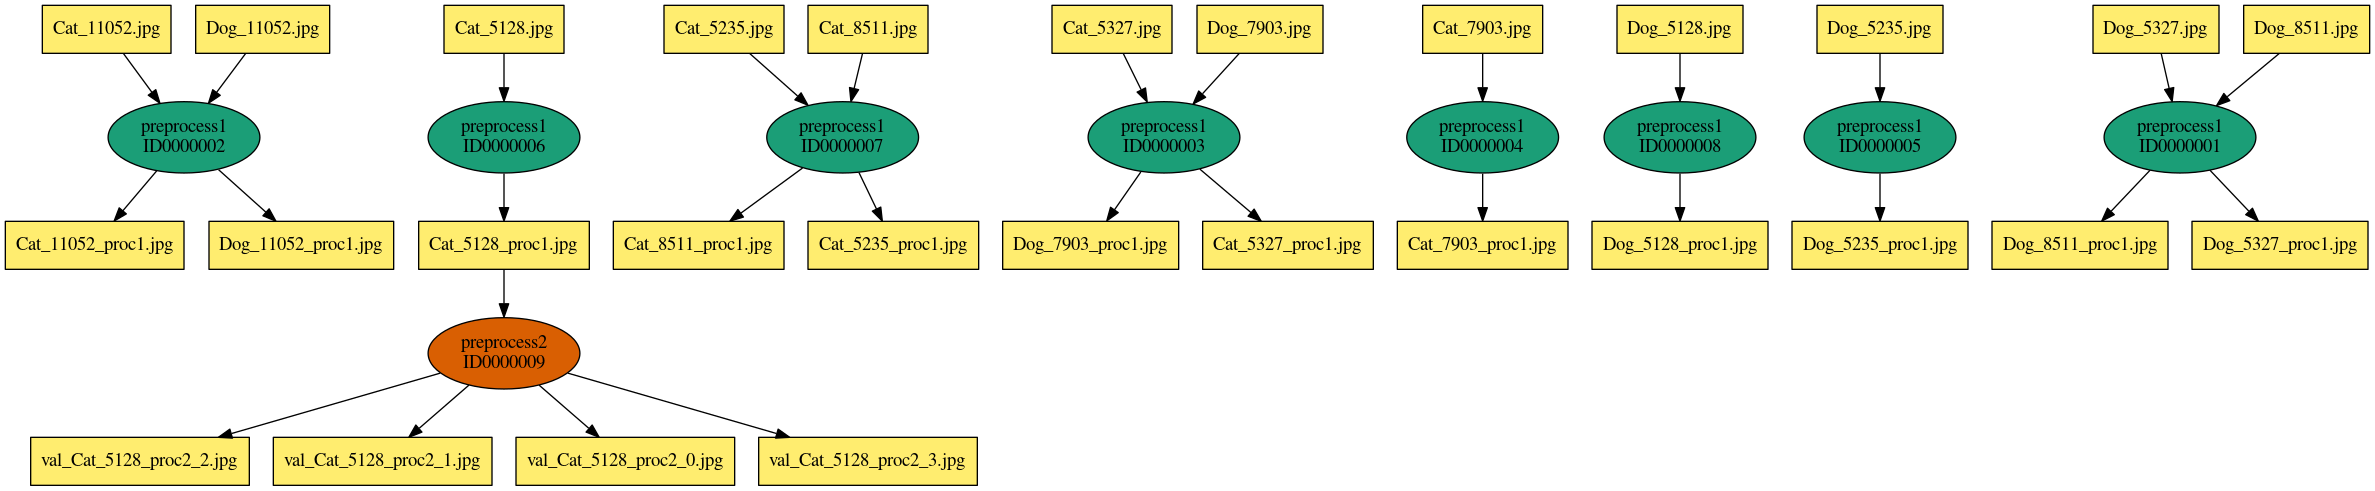

In [24]:
from IPython.display import Image
Image(filename='graph_2prejobs.png')